In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import GPy
from BNN_Dropout import NN_Dropout, BNN_Dropout
from BNN_SGDHMC import BNN_SGDHMC
from Benchmark import RandomNN
from pybnn.bohamiann import Bohamiann

plt.rcParams['figure.figsize'] = (12.0, 8)


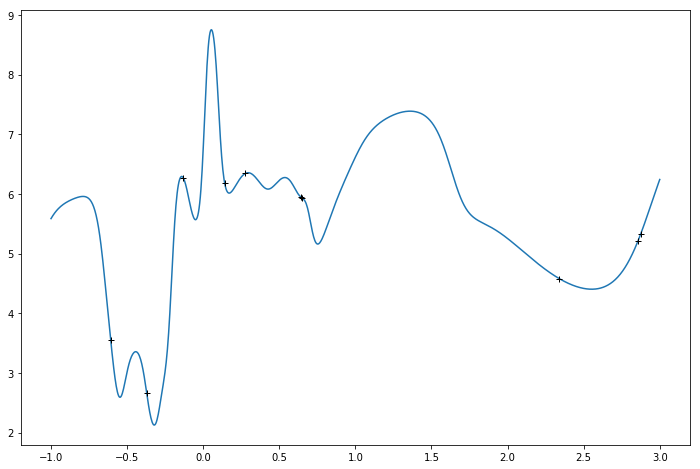

In [56]:
bench = RandomNN(1,3,50,nn.Tanh())
bench.rand_normal_weight(1)
num_plot  = 1000
num_train = 10
x = torch.linspace(-1,3,num_plot)[:,None]
y = bench(x)
train_id = np.random.permutation(num_plot)[:num_train]
train_x = x[train_id]
train_y = y[train_id]
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')

In [72]:
conf = dict()
conf['num_epochs'] = 16000
conf['num_hidden'] = 50
conf['num_layers'] = 3
conf['batch_size'] = 128


conf['dropout_rate'] = 0.1
conf['lr']           = 1e-4
conf['tau']        =  100
conf['lscale']     = 0


model = BNN_Dropout(1,nn.Tanh(), conf)

conf_hmc = dict()
hmc_model = BNN_SGDHMC(dim = 1, act = nn.Tanh(), conf = conf_hmc)
kern = GPy.kern.RBF(input_dim = 1)
gp = GPy.models.GPRegression(X=train_x.numpy(), Y= train_y.detach().numpy(), kernel=kern)
gp.likelihood.variance = 1e-2

In [73]:
hmc_model.train(train_x, train_y)
model.train(train_x, train_y)
gp.optimize()

Step      100 : NLL =  7.3970e+02 MSE = 2.4607e+00 Time =  0.54
Step      200 : NLL =  9.5350e+02 MSE = 2.7821e+00 Time =  1.00
Step      300 : NLL =  1.1829e+03 MSE = 2.8041e+00 Time =  1.45
Step      400 : NLL =  1.4034e+03 MSE = 2.7945e+00 Time =  2.05
Step      500 : NLL =  1.6870e+03 MSE = 2.7981e+00 Time =  2.55
Step      600 : NLL =  2.0786e+03 MSE = 2.8401e+00 Time =  2.99
Step      700 : NLL =  2.4600e+03 MSE = 2.8146e+00 Time =  3.42
Step      800 : NLL =  2.9629e+03 MSE = 2.7908e+00 Time =  3.95
Step      900 : NLL =  3.6567e+03 MSE = 2.8400e+00 Time =  4.46
Step     1000 : NLL =  4.2700e+03 MSE = 2.8121e+00 Time =  4.90
Step     1100 : NLL =  5.1941e+03 MSE = 2.8075e+00 Time =  5.46
Step     1200 : NLL =  6.2803e+03 MSE = 2.7939e+00 Time =  5.87
Step     1300 : NLL =  7.5468e+03 MSE = 2.8162e+00 Time =  6.42
Step     1400 : NLL =  9.2895e+03 MSE = 2.8244e+00 Time =  6.93
Step     1500 : NLL =  1.1713e+04 MSE = 2.8193e+00 Time =  7.42
Step     1600 : NLL =  1.4830e+04 MSE = 

 /mnt/c/code/pybnn/pybnn/bohamiann.py:119: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Step     2100 : NLL =  3.5438e+04 MSE = 2.8309e+00 Samples= 1 Time = 10.08
Step     2200 : NLL =  6.3222e+03 MSE = 2.8245e+00 Samples= 3 Time = 10.46
Step     2300 : NLL =  5.4417e+03 MSE = 2.8217e+00 Samples= 5 Time = 10.89
Step     2400 : NLL =  5.9723e+03 MSE = 2.8175e+00 Samples= 7 Time = 11.34
Step     2500 : NLL =  6.6891e+03 MSE = 2.8167e+00 Samples= 9 Time = 11.76
Step     2600 : NLL =  7.3262e+03 MSE = 2.8169e+00 Samples= 11 Time = 12.32
Step     2700 : NLL =  7.9604e+03 MSE = 2.8168e+00 Samples= 13 Time = 12.84
Step     2800 : NLL =  7.5457e+03 MSE = 2.8163e+00 Samples= 15 Time = 13.21
Step     2900 : NLL =  7.4498e+03 MSE = 2.8165e+00 Samples= 17 Time = 13.56
Step     3000 : NLL =  7.7004e+03 MSE = 2.8162e+00 Samples= 19 Time = 13.92
Step     3100 : NLL =  6.7147e+03 MSE = 2.8151e+00 Samples= 21 Time = 14.26
Step     3200 : NLL =  6.4324e+03 MSE = 2.8146e+00 Samples= 23 Time = 14.62
Step     3300 : NLL =  6.8213e+03 MSE = 2.8147e+00 Samples= 25 Time = 15.01
Step     3400 : N

Text(0.5,1,'Gaussian process')

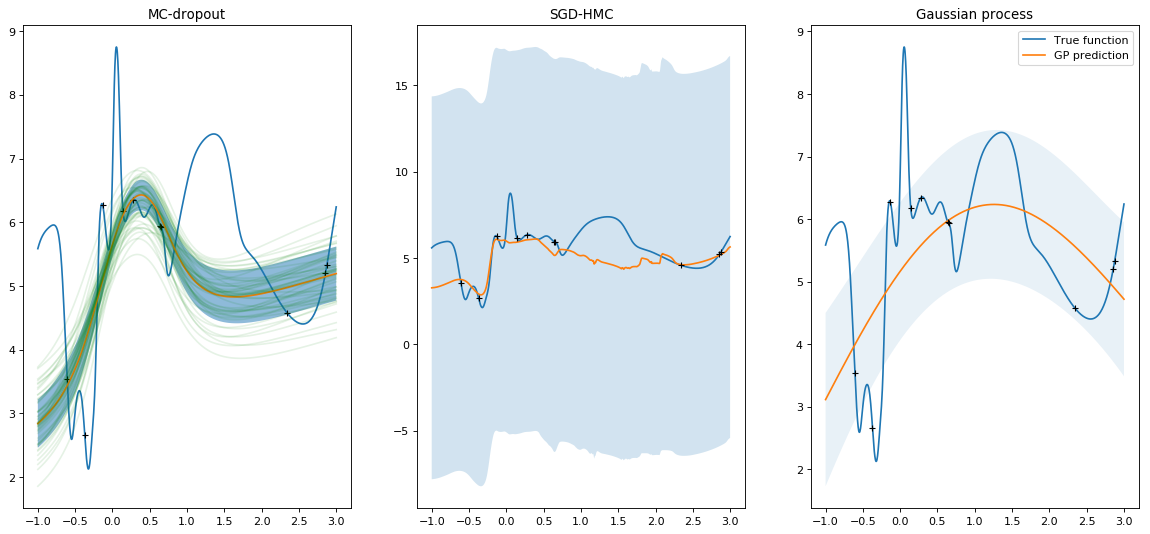

In [74]:
#py = model.predict(x)
py,pv = model.predict_mv(x)
ps = torch.sqrt(pv)
m_hmc,v_hmc = hmc_model.predict_mv(x)
m_hmc = m_hmc.detach().numpy().reshape(num_plot)
s_hmc   = v_hmc.sqrt().detach().numpy().reshape(num_plot)
fig=plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')


plt.subplot(131)
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.plot(x.numpy(),py.detach().numpy(),label = 'Pred')
plt.fill_between(
    x.numpy().reshape(num_plot), 
    (py - ps).reshape(num_plot).detach().numpy(), 
    (py + ps).reshape(num_plot).detach().numpy(), alpha = 0.5)
for i in range(50):
    net = model.sample()
    py  = net((x - model.x_mean) / model.x_std) * model.y_std + model.y_mean
    plt.plot(x.numpy(),py.detach().numpy(), 'g', alpha = 0.1)
plt.title('MC-dropout')

plt.subplot(132)
plt.plot(x.numpy(), y.detach().numpy())
plt.plot(x.numpy(), m_hmc)
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.fill_between(x.numpy().reshape(num_plot), m_hmc + s_hmc, m_hmc - s_hmc, alpha = 0.2)
plt.title('SGD-HMC')

plt.subplot(133)
gp_m, gp_v = gp.predict(x.numpy())
plt.plot(x.numpy(), y.detach().numpy(), label = 'True function')
plt.plot(x.numpy(), gp_m, label = 'GP prediction')
plt.plot(train_x.numpy(), train_y.detach().numpy(),'k+')
plt.fill_between(x.numpy().reshape(num_plot), (gp_m - np.sqrt(gp_v)).reshape(num_plot), (gp_m + np.sqrt(gp_v)).reshape(num_plot), alpha = 0.1)
plt.legend()
plt.title('Gaussian process')

In [46]:
pv

tensor([0.0602, 0.0602, 0.0602, 0.0601, 0.0601, 0.0601, 0.0601, 0.0600, 0.0600,
        0.0600, 0.0600, 0.0600, 0.0599, 0.0599, 0.0599, 0.0599, 0.0598, 0.0598,
        0.0598, 0.0598, 0.0598, 0.0598, 0.0597, 0.0597, 0.0597, 0.0597, 0.0597,
        0.0597, 0.0597, 0.0597, 0.0597, 0.0596, 0.0596, 0.0596, 0.0596, 0.0596,
        0.0596, 0.0596, 0.0596, 0.0596, 0.0596, 0.0596, 0.0596, 0.0596, 0.0596,
        0.0596, 0.0597, 0.0597, 0.0597, 0.0597, 0.0597, 0.0597, 0.0598, 0.0598,
        0.0598, 0.0598, 0.0598, 0.0599, 0.0599, 0.0599, 0.0600, 0.0600, 0.0600,
        0.0601, 0.0601, 0.0602, 0.0602, 0.0603, 0.0603, 0.0604, 0.0604, 0.0605,
        0.0606, 0.0606, 0.0607, 0.0608, 0.0608, 0.0609, 0.0610, 0.0611, 0.0611,
        0.0612, 0.0613, 0.0614, 0.0615, 0.0616, 0.0617, 0.0618, 0.0619, 0.0621,
        0.0622, 0.0623, 0.0624, 0.0626, 0.0627, 0.0628, 0.0630, 0.0631, 0.0633,
        0.0634, 0.0636, 0.0637, 0.0639, 0.0641, 0.0643, 0.0644, 0.0646, 0.0648,
        0.0650, 0.0652, 0.0654, 0.0656, 

In [35]:
for i in range(len(xs)):
    if np.isnan(xs[i]):
        del xs[i]

IndexError: list index out of range

100.0